# Майнор Интеллектуальный анализ данных / Введение в анализ данных

## Домашнее задание 3. Логистическая регрессия и случайный лес.

В этом задании вам предстоит:
- поработать с логистической регрессией (полная реализация не потребуется, однако можно заработать бонусные баллы)
- воспроизвести подход случайного леса через одно решающее дерево, поэкспериментировать со случайным лесом.

На все вопросы требуется отвечать развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.
- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.04.2018
- Срок сдачи: 23:59 18.05.2018

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Часть 0. Подготовка данных.

Для наших экспериентов возьмём обучающую выборку [отсюда](https://www.kaggle.com/iabhishekofficial/mobile-price-classification).

In [65]:
train = pd.read_csv('train.csv')

Решается задача многоклассовой классификации — определение ценовой категории телефона. Для простоты перейдём к задаче бинарной классификации — пусть исходные классы 0 и 1 соответствуют классу 0 новой целевой переменной, а остальные классу 1.

Замените целевую переменную, отделите её в отдельную переменную и удалите из исходной выборки.

In [66]:
price_range = train['price_range']
train['price_range'] = train['price_range'].replace(to_replace = [0, 1, 2, 3], value = [0, 0, 1, 1])

Разделите выборку на обучающую и тестовую части в соотношении 7 к 3. Для этого можно использовать `train_test_split` из scikit-learn. Не забудьте зафиксировать сид для разбиения.

In [67]:
from sklearn import model_selection
np.random.seed(42)
train_X, test_X = model_selection.train_test_split(train, train_size = 0.7, test_size = 0.3)
train_Y, test_Y = train_X['price_range'], test_X['price_range']
train_Y = train_Y.reshape(-1, 1)
test_Y = test_Y.reshape(-1, 1)
del train_X['price_range']
del test_X['price_range']

/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


## Часть 1. Логистическая регрессия.

[4 балла]

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$

Не забывайте, что для линейных методов матрицу объекты-признаки необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из способов). Для этого можно воспользоваться `StandardScaler` или сделать это вручную.

In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.fit_transform(test_X)

Обучите логистическую регрессию. Сделайте предсказания для тестовой части, посчитайте по ним ROC-AUC и Accuracy (порог 0.5). Хорошо ли удаётся предсказывать целевую переменную?

Не забывайте, что метод `predict_proba` вычисляет вероятности обоих классов выборки, а в бинарной классификации нас интересует в первую очередь вероятность принадлежности к положительному классу.

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
LR = LogisticRegression()
LR.fit(train_X, train_Y)
Y_predict = LR.predict(test_X)
Y_predict_proba = LR.predict_proba(test_X)
Y_predict_proba = np.swapaxes(Y_predict_proba, 0, 1)
Y_predict_proba = Y_predict_proba[1]
print(roc_auc_score(test_Y, Y_predict_proba))
print(accuracy_score(test_Y, Y_predict))

0.999733306664
0.983333333333


/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


У обученной логистической регрессии есть два аттрибута: `coef_` и `intercept_`, которые соответствуют весам $w$ и $w_0$. Это и есть результат обучения логистической регрессии. Попробуйте с помощью них (с помощью всё той же обученной ранее логистической регрессии) посчитать "сырое" предсказание алгоритма $b(x)$. 

Постройте гистограмму полученных значений и ответьте на вопросы:
- Какие значения принимает такое предсказание?
- Похожи ли эти значения на вероятность классов?

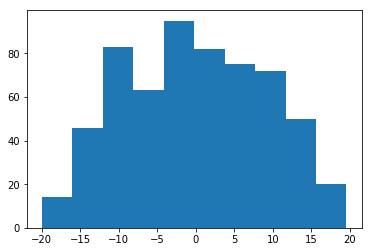

In [127]:
w, w_0 = LR.coef_[0], LR.intercept_
b = [(w_0 + sum(w[i] * test_X[x][i] for i in range(20)))[0] for x in range(600)]
pyplot.hist(b)
pyplot.show()

Вектор b принимает значения от 0 до 100. Нет, не похожи, т. к., вероятность принимает значения от 0 до 1.

Реализуйте сигмоиду и постройте её график. Что вы можете сказать об этой функции?

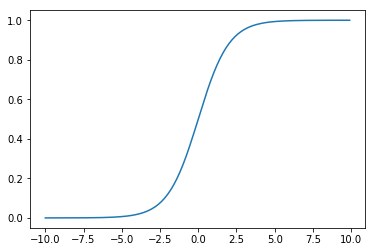

In [88]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
X = np.arange(-10.0, 10.0, 0.1)
Y = [sigmoid(x) for x in X]
pyplot.plot(X, Y)
pyplot.show()

Примените реализованную сигмоиду к $b(x)$. Вы должны получить вероятности принадлежности к положительному классу. Проверьте, что ваши значения совпали с теми, которые получены с помощью `predict_proba`.

In [134]:
sigmoid_b = [sigmoid(i) for i in b]
print(sigmoid_b[:10])
print(Y_predict_proba[:10])

[4.1110179541095578e-05, 0.89151406220886287, 0.0099163984061175128, 0.99999563158504379, 0.20424903228411476, 0.13231349351170862, 0.59495609925557336, 2.7899242635127476e-05, 0.99962676636917536, 0.1681881613665871]
[  4.11101795e-05   8.91514062e-01   9.91639841e-03   9.99995632e-01
   2.04249032e-01   1.32313494e-01   5.94956099e-01   2.78992426e-05
   9.99626766e-01   1.68188161e-01]


In [ ]:
Значения совпадают.

Таким образом, обучение логистической регрессии — настройка параметров $w$ и $w_0$, а применение — подсчёт вероятностей принадлежности положительному классу как применение сигмоды к скалярному произведению признаков и параметров.

Постройте для обученной логистической регрессии ROC-кривую `roc_curve` и PR-кривую `precision_recall_curve`.

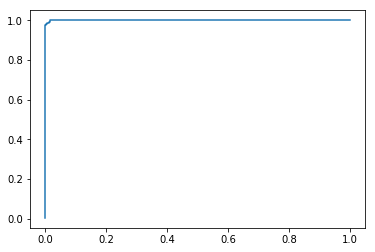

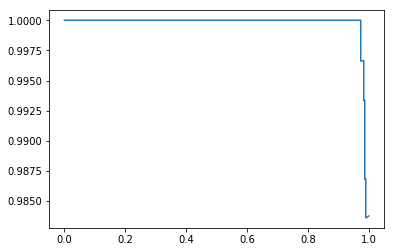

In [141]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
fpr, tpr, thresholds = roc_curve(test_Y, Y_predict_proba)
pyplot.plot(fpr, tpr)
pyplot.show()
precision, recall, thresholds = precision_recall_curve(test_Y, Y_predict_proba)
pyplot.plot(recall, precision)
pyplot.show()

### Бонусное задание. Обучение логистической регрессии.

[2 бонусных балла]

Если выше вручную мы только применяли логистическую регрессию, то здесь предлагается реализовать обучение с помощью полного градиентного спуска.

Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.

Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково. 

В качестве критерия останова необходимо использовать (одновременно):
- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max\_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Реализуйте обучение логистической регрессии. Для удобства ниже предоставлен прототип с необходимыми методами. В `loss_history` необходимо сохранять вычисленное на каждой итерации значение функции потерь. 

In [ ]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, lambda_2=1.0, tolerance=1e-4, max_iter=1000, alpha=1e-3):
        """
        lambda_2: L2 regularization param
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        alpha: learning rate
        """
        self.lambda_2 = lambda_2
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.alpha = alpha
        self.w = None
        self.loss_history = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        
        pass
        
        return self
    
    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')
        
        pass
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        pass

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        pass

1. Примените логистическую регресиию на той же выборке.
2. Посчитайте качество по тем же метрикам.
3. Визуализируйте изменение значений функции потерь от номера итераций.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 2. Случайные леса.

[6 баллов]

Случайный лес — алгоритм машинного обучения, представляющий собой бэггинг над решающими деревьями (усреднение ответов множества слабых алгоритмов) с 2 основными идеями:
- Использование подмножества признаков при построении каждого сплита дерева.
- Бутстрап обучающей выборки для построения каждого дерева (с повторениями).

В этом задании мы попробуем оценить пользу каждой из идей. Будем использовать ту же выборку с тем же разбиением на 2 части. Для начала обучите решающее дерево `DecisionTreeClassifier` из scikit-learn и посчитайте ROC-AUC и Accuracy (порог 0.5). Не забудьте зафикиксировать сид для построения дерева (несмотря на то, что в классической реализации никакой случайности нет, при большой глубине дерева может возникать неоднозначность в выборке признака в сплите). Используйте этот сид для всех заданий ниже.

In [143]:
np.random.seed(42)
from sklearn.tree import DecisionTreeClassifier
DecisionTree = DecisionTreeClassifier()
DecisionTree.fit(train_X, train_Y)
Y_predict = DecisionTree.predict(test_X)
Y_predict_proba = DecisionTree.predict_proba(test_X)
Y_predict_proba = np.swapaxes(Y_predict_proba, 0, 1)
Y_predict_proba = Y_predict_proba[1]
print(roc_auc_score(test_Y, Y_predict_proba))
print(accuracy_score(test_Y, Y_predict))

0.934910157682
0.935


### 2.1 Бэггинг классификаторов

Реализуйте бэггинг над решающими деревьями (усреднение предсказанных вероятностей всего ансамбля). 
В качестве основы используйте всё тот же `DecisionTreeClassifier`. Количество базовых алгоритмов предлагается брать равным 100. 

Посчитайте качество с помощью тех же метрик. Ответьте на следующие вопросы:
- Что интересного вы видите?
- С чем это связано?

In [154]:
Y_pred_prob = np.zeros(600)
Y_pred = np.zeros(600)
for i in range(100):
    DecisionTree = DecisionTreeClassifier()
    DecisionTree.fit(train_X, train_Y)
    Y_predict = DecisionTree.predict(test_X)
    Y_predict_proba = DecisionTree.predict_proba(test_X)
    Y_predict_proba = np.swapaxes(Y_predict_proba, 0, 1)
    Y_predict_proba = Y_predict_proba[1]
    Y_pred_prob = [sum(x) for x in zip(Y_pred_prob, Y_predict_proba)]
    Y_pred = [sum(x) for x in zip(Y_pred, Y_predict)]
for i in range(len(Y_pred)):
    Y_pred[i] //= 100
    Y_pred_prob[i] /= 100
print(roc_auc_score(test_Y, np.asarray(Y_pred_prob)))
print(accuracy_score(test_Y, np.asarray(Y_pred)))

0.954267648987
0.933333333333


ROC-AUC выросла, а accuracy уменьшился.

### 2.2 Сэмплирование обучающей выборки

Добавим к нашему бэггингу бутстрап выборки (генерация случайной выборки того же размера с возвращением). Для этого может пригодиться `numpy.random.randint`.

Посчитайте качество. Что вы видите?

In [156]:
np.random.seed(123)  # для одинакового бутстрапа в каждом запуске

Y_pred_prob = np.zeros(600)
Y_pred = np.zeros(600)
for i in range(100):
    sample = np.random.randint(low = 0, high = 601, size = 600)
    train_X_sample = train_X[sample]
    train_Y_sample = train_Y[sample]
    DecisionTree = DecisionTreeClassifier()
    DecisionTree.fit(train_X_sample, train_Y_sample)
    Y_predict = DecisionTree.predict(test_X)
    Y_predict_proba = DecisionTree.predict_proba(test_X)
    Y_predict_proba = np.swapaxes(Y_predict_proba, 0, 1)
    Y_predict_proba = Y_predict_proba[1]
    Y_pred_prob = [sum(x) for x in zip(Y_pred_prob, Y_predict_proba)]
    Y_pred = [sum(x) for x in zip(Y_pred, Y_predict)]
for i in range(len(Y_pred)):
    Y_pred[i] //= 100
    Y_pred_prob[i] /= 100
print(roc_auc_score(test_Y, np.asarray(Y_pred_prob)))
print(accuracy_score(test_Y, np.asarray(Y_pred)))

0.99204920492
0.758333333333


ROC-AUC выросла, а accuracy уменьшился.

### 2.3 Выбор случайного подмножества признаков

Временно забудем о бутстрапе выборки и добавим выбор случайного подмножества признаков при построении каждого сплита. В `DecisionTreeClassifier` за это отвечает параметр `max_features`. По умолчанию он имеет значение `None`, что обозначает использование всех возможных признаков. Для задачи классификации рекоменуется использовать квадратный корень от количества признаков. Попробуйте выставить такое значение. На этот раз надо отключить фиксированный сид в построении дерева, так как иначе каждый раз мы будем выбирать одинаковые подмножества признаков. 

Посчитайте качество. Что вы видите?

In [157]:
np.random.seed(123)  # для воспроизводимости построения случайных подмножеств признаков

Y_pred_prob = np.zeros(600)
Y_pred = np.zeros(600)
for i in range(100):
    DecisionTree = DecisionTreeClassifier(max_features='sqrt')
    DecisionTree.fit(train_X, train_Y)
    Y_predict = DecisionTree.predict(test_X)
    Y_predict_proba = DecisionTree.predict_proba(test_X)
    Y_predict_proba = np.swapaxes(Y_predict_proba, 0, 1)
    Y_predict_proba = Y_predict_proba[1]
    Y_pred_prob = [sum(x) for x in zip(Y_pred_prob, Y_predict_proba)]
    Y_pred = [sum(x) for x in zip(Y_pred, Y_predict)]
for i in range(len(Y_pred)):
    Y_pred[i] //= 100
    Y_pred_prob[i] /= 100
print(roc_auc_score(test_Y, np.asarray(Y_pred_prob)))
print(accuracy_score(test_Y, np.asarray(Y_pred)))

0.991876965474
0.495


ROC-AUC выросла, а accuracy уменьшился.

### 2.4 = 2.2 + 2.3

Объединим два подхода (бутстрап + выбор подмножества признаков). Получим случайный лес.

Посчитайте качество. Что вы видите?

In [158]:
np.random.seed(123)  # для одинакового бутстрапа и выбора подмножеств признаков в каждом запуске

Y_pred_prob = np.zeros(600)
Y_pred = np.zeros(600)
for i in range(100):
    sample = np.random.randint(low = 0, high = 601, size = 600)
    train_X_sample = train_X[sample]
    train_Y_sample = train_Y[sample]
    DecisionTree = DecisionTreeClassifier(max_features='sqrt')
    DecisionTree.fit(train_X_sample, train_Y_sample)
    Y_predict = DecisionTree.predict(test_X)
    Y_predict_proba = DecisionTree.predict_proba(test_X)
    Y_predict_proba = np.swapaxes(Y_predict_proba, 0, 1)
    Y_predict_proba = Y_predict_proba[1]
    Y_pred_prob = [sum(x) for x in zip(Y_pred_prob, Y_predict_proba)]
    Y_pred = [sum(x) for x in zip(Y_pred, Y_predict)]
for i in range(len(Y_pred)):
    Y_pred[i] //= 100
    Y_pred_prob[i] /= 100
print(roc_auc_score(test_Y, np.asarray(Y_pred_prob)))
print(accuracy_score(test_Y, np.asarray(Y_pred)))

0.985593003745
0.495


И ROC-AUC, и accuracy немного уменьшились.

То, что мы сделали уже реализовано в `RandomForestClassifier`. Попробуйте воспользоваться им. Количество используемых деревьев передаётся в параметре `n_estimators`.

Посчитайте качество. Что вы видите?

In [160]:
from sklearn.ensemble import RandomForestClassifier
RandomForest = RandomForestClassifier(n_estimators=100)
RandomForest.fit(train_X, train_Y)
Y_predict = RandomForest.predict(test_X)
Y_predict_proba = RandomForest.predict_proba(test_X)
Y_predict_proba = np.swapaxes(Y_predict_proba, 0, 1)
Y_predict_proba = Y_predict_proba[1]
print(roc_auc_score(test_Y, np.asarray(Y_predict_proba)))
print(accuracy_score(test_Y, np.asarray(Y_predict)))

/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.993393783823
0.96


И ROC-AUC и accuracy выросли.

### 2.5 Влияние количества используемых деревьев в случайном лесе

Один из параметров случайного леса — количество деревьев, используемых в бэггинге. Оценим, как влияет этот параметр на финальное качество. Для этого обучите случайные леса с разным количество деревьев (например, перебирайте от 10 до 1000 с шагом в 10), оцените качество с помощью ROC-AUC. Постройте график зависимости ROC-AUC от количества используемых деревьев. Что вы видите?

/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/Users/olgap

/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/Users/olgap

/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/Users/olgap

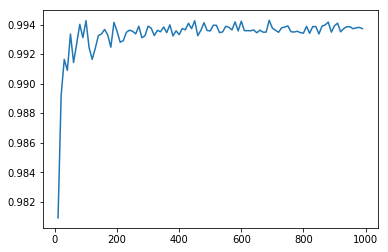

In [171]:
n_estimators = range(10, 1000, 10)
ROC_AUCs = []
for n in n_estimators:
    RandomForest = RandomForestClassifier(n_estimators=n)
    RandomForest.fit(train_X, train_Y)
    Y_predict_proba = RandomForest.predict_proba(test_X)
    Y_predict_proba = np.swapaxes(Y_predict_proba, 0, 1)
    Y_predict_proba = Y_predict_proba[1]
    ROC_AUCs.append(roc_auc_score(test_Y, np.asarray(Y_predict_proba)))
pyplot.plot(n_estimators, ROC_AUCs)
pyplot.xlabel = 'Number of estimators'
pyplot.ylabel = 'ROC-AUC'
pyplot.show()

ROC-AUC растёт при n < 200, и дальше остаётся на примерно одном уровне.

### 2.6 Важность признаков

Случайный лес позволяет оценить важность признаков. У обученного случайного леса есть аттрибут `feature_importances_`, где храниться важность для каждого признака. Постройте `barplot` с важностью признаков (удобно использовать библиотеку `seaborn`, где можно для каждого столбца передать название признака `train.columns`).

/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


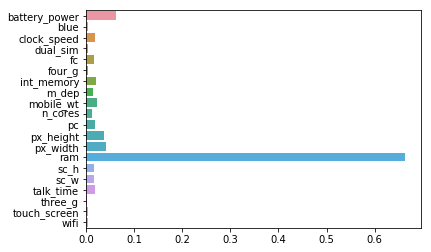

In [180]:
import seaborn

RandomForest = RandomForestClassifier(n_estimators=100)
RandomForest.fit(train_X, train_Y)
seaborn.barplot(x = RandomForest.feature_importances_, y = train.columns)

## Выводы

Напишите, что интересного вы узнали в этой работе, в каких экспериментах какие результаты получились.

- ROC-AUC был выше всего у логистической регрессии.
- Accuracy была выше всего у логистической регрессии.
- У случайного леса самая высокая ROC-AUC была при n_estimators = 100
- Самый важный признак -- RAM.